# Determine causal drivers of trends in LSP metrics, perpixel


In [1]:
%matplotlib inline

import os
import sys
import warnings
import numpy as np
import xarray as xr
import pandas as pd

import dask
import dask.array
from dask import delayed
from odc.geo.xr import assign_crs
import matplotlib.pyplot as plt

import sys
sys.path.append('/g/data/os22/chad_tmp/Aus_phenology/src')
from phenology_pixel import pls_phenology_modelling

sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _utils import round_coords
from _prediction import allNaN_arg

%load_ext autoreload
%autoreload 2

/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


## Dask cluster

Local or Dynamic?

https://github.com/NCI900-Training-Organisation/Distributed-Dask-Cluster-on-Gadi

In [ ]:
sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _utils import start_local_dask
start_local_dask(n_workers=51, threads_per_worker=1, memory_limit='200GiB')

In [ ]:
# from dask.distributed import Client
# from dask_jobqueue import PBSCluster

# cpus=52
# mem='240GB'
# extra = ['-q normalsr',
#          '-P w97', 
#          '-l ncpus='+str(cpus), 
#          '-l mem='+mem,
#         '-l storage=gdata/os22+gdata/w97'
#         ]
# setup_commands = ["module load python3/3.10.0", "source /g/data/os22/chad_tmp/AusENDVI/env/py310/bin/activate"]

# cluster = PBSCluster(walltime="01:00:00", 
#                      cores=cpus,
#                      processes=cpus,
#                      memory=mem,
#                      shebang='#!/usr/bin/env bash',
#                      job_extra_directives=extra, 
#                      local_directory='/g/data/os22/chad_tmp/Aus_phenology/data', 
#                      job_directives_skip=["select"], 
#                      interface="ib0",
#                      job_script_prologue=setup_commands,
#                     )

# # print(cluster.job_script())
# cluster.scale(jobs=1)
# client = Client(cluster)
# client

# client.shutdown()
# cluster.close()

## Open data

In [ ]:
ds = xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/data/NDVI/NDVI_smooth_AusENDVI-clim_MCD43A4.nc')['NDVI']
# ds = ds.isel(latitude=slice(200,352), longitude=slice(50,302))
# ds = ds.isel(latitude=slice(400,425), longitude=slice(100,125))

covariables =  xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/data/covars.nc')
covariables = covariables.drop_vars('wcf')
# covariables = covariables.isel(latitude=slice(200,352), longitude=slice(50,302))

### Split data into tiles

Running all of Aus just takes too long, >500,000 pixels * > 14,000 time steps - dask graph is huge

In [ ]:
# Function to split into spatial tiles
def split_spatial_tiles(data_array, lat_dim='latitude', lon_dim='longitude', n_lat=2, n_lon=4):
    lat_size = data_array.sizes[lat_dim] // n_lat
    lon_size = data_array.sizes[lon_dim] // n_lon
    
    tiles = []
    for i in range(n_lat):
        for j in range(n_lon):
            tile = data_array.isel({
                lat_dim: slice(i * lat_size, (i + 1) * lat_size),
                lon_dim: slice(j * lon_size, (j + 1) * lon_size)
            })
            tiles.append(tile)
    
    return tiles


# Split data into spatial tiles (2 latitude x 4 longitude)
tiles = split_spatial_tiles(ds, n_lat=2, n_lon=4)
covars_tiles = split_spatial_tiles(covariables, n_lat=2, n_lon=4)

#verify no overlaps or missing pixels.
assert np.sum(xr.combine_by_coords(tiles).longitude == ds.longitude) == len(ds.longitude)
assert np.sum(xr.combine_by_coords(tiles).latitude == ds.latitude) == len(ds.latitude)

# create named dictonary
tile_names=['NW', 'NNW', 'NNE', 'NE',
            'SW', 'SSW', 'SSE', 'SE']
tiles_dict = dict(zip(tile_names, tiles))
covars_tiles_dict = dict(zip(tile_names, covars_tiles))

#create a plot to visualise tiles
fig,axes = plt.subplots(2, 4, figsize=(10,8))
for t,ax in zip(tiles, axes.ravel()):
    t.isel(time=range(0,20)).mean('time').plot(ax=ax, add_colorbar=False, add_labels=False)
    ax.set_title(None);

## Relationships between phenometrics and climate

Because we don't have the phenology time series of every pixel saved, we need to re-compute phenology and then assess the relationships between the covariables and the phenometric and again return only the summarised results.

In [ ]:
%%capture
for (n,d),(nn,dd) in zip(tiles_dict.items(), covars_tiles_dict.items()):
    
    if os.path.exists(f'/g/data/os22/chad_tmp/Aus_phenology/results/causal_tiles/pls_modelling_perpixel_{n}.nc'):
        continue
    
    else:
    
        print('Working on tile: '+ n)
        
        ### --------Handle NaNs---------
        # Due to issues with xarray quadratic interpolation, we need to remove
        # every NaN or else the daily interpolation function will fail
        
        ##remove last ~6 timesteps that are all-NaN (from S-G smoothing).
        times_to_keep = d.mean(['latitude','longitude']).dropna(dim='time',how='any').time
        d = d.sel(time=times_to_keep)
        
        #Find where NaNs are >10 % of data, will use this mask to remove pixels later.
        #and include any NaNs in the climate data.
        ndvi_nan_mask = np.isnan(d).sum('time') >= len(d.time) / 10
        clim_nan_mask = dd[['rain','vpd','tavg','srad']].to_array().isnull().any('variable')
        clim_nan_mask = (clim_nan_mask.sum('time')>0)
        nan_mask = (clim_nan_mask | ndvi_nan_mask)

        d = d.where(~nan_mask)
        dd = dd.where(~nan_mask)
        # nan_mask.to_netcdf(f'/g/data/os22/chad_tmp/Aus_phenology/data/ndvi_tiles/nan_mask_{n}.nc')
        
        #fill the mostly all NaN slices with a fill value
        d = xr.where(nan_mask, -99, d)
        
        #interpolate away any remaining NaNs
        d = d.interpolate_na(dim='time', method='cubic', fill_value="extrapolate")
        
        #now we can finally interpolate to daily
        d = d.resample(time='1D').interpolate(kind='quadratic').astype('float32')
        
        # We also need the shape of the stacked array
        shape = d.stack(spatial=('latitude', 'longitude')).values.shape
        
        #stack spatial indexes, this makes it easy to loop through data
        y_stack = d.stack(spatial=('latitude', 'longitude'))
        Y = y_stack.transpose('time', 'spatial')
        
        x_stack = dd.stack(spatial=('latitude', 'longitude'))
        X = x_stack.transpose('time', 'spatial')
        
        # find spatial indexes where values are mostly NaN (mostly land-sea mask)
        # This is where the nan_mask we created earlier = True
        idx_all_nan = np.where(nan_mask.stack(spatial=('latitude', 'longitude'))==True)[0]
        
        # open template array which we'll use 
        # whenever we encounter an all-NaN index.
        # Created the template using one of the output results
        # bb = xr.full_like(results[0], fill_value=-np.nan, dtype='float32')
        template_path='/g/data/os22/chad_tmp/Aus_phenology/data/template_pls.nc'
        ds_template = xr.open_dataset(template_path).sel(feature=['co2','srad', 'rain','tavg', 'vpd'])
        
        #now we start the real proceessing
        results=[]
        for i in range(shape[1]): #loop through all spatial indexes.
        
            #select pixel
            data = Y.isel(spatial=i)
            covar = X.isel(spatial=i)
            
            # First, check if spatial index has data. If its one of 
            # the all-NaN indexes then return xarray filled with -99 values
            if i in idx_all_nan:
                xx = ds_template.copy() #use our template    
                xx['latitude'] = [data.latitude.values.item()] #update coords
                xx['longitude'] = [data.longitude.values.item()]
            
            else:
                xx = pls_phenology_modelling(
                    data,
                    covar,
                    rolling=90,
                    distance=90,
                    prominence='auto',
                    plateau_size=10
                )

            #return results, either NaN or answer
            results.append(xx)

        # #bring into memory this will take a long time
        results = dask.compute(results)[0]
            
        p_attribution = xr.combine_by_coords(results)
        
        #assign crs and export
        p_attribution = assign_crs(p_attribution, crs='EPSG:4326')
        p_attribution.to_netcdf(f'/g/data/os22/chad_tmp/Aus_phenology/results/causal_tiles/pls_modelling_perpixel_{n}.nc');


In [12]:
p_attribution = xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/results/causal_tiles/pls_modelling_perpixel_SE.nc')

In [ ]:
fig,axes=plt.subplots(1,5,figsize=(18,4))
for v,ax in zip(p_attribution.feature.values,axes.ravel()):
    p_attribution.sel(feature=v).PLS_coefficent.plot(add_labels=False,ax=ax, vmin=-0.03,vmax=0.03,cmap='RdBu')
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    ax.set_title(v)

In [ ]:
ss = allNaN_arg(np.abs(p_attribution.PLS_coefficent), dim='feature',stat='max', idx=False)
im = ss.plot(add_colorbar=False, figsize=(5,8), add_labels=False)
cbar = fig.colorbar(im, ticks=[0,1,2,3,4], orientation='horizontal')
cbar.ax.set_xticklabels(list(p_attribution.feature.values));

## Join tiles together

In [34]:
tiles_path = '/g/data/os22/chad_tmp/Aus_phenology/results/causal_tiles/'
attrs_tiles = [tiles_path+i for i in os.listdir(tiles_path) if i.endswith('.nc')]
attrs_tiles = [xr.open_dataset(t) for t in attrs_tiles]

clean_tiles = []
for t in attrs_tiles:
    try:
        ds = t.drop_vars('phenometric')
        clean_tiles.append(ds)
    except:
        clean_tiles.append(t)


p_attribution = xr.combine_by_coords(attrs_tiles)
p_attribution = assign_crs(p_attr,crs='EPSG:4326')

# for var in p_attribution.data_vars:
#     del p_attribution[var].attrs['grid_mapping']

In [35]:
# p_attr.sel(feature='vpd').PLS_coefficent.plot(robust=True)


## Mask urban, water, irrigated regions

In [36]:
crops = xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/data/croplands_5km.nc')['croplands']
crops = xr.where(crops==2, 0, 1) #irrigated crops
crops = round_coords(crops)

urban = xr.open_dataarray('/g/data/os22/chad_tmp/AusEFlux/data/urban_mask_5km.nc').rename({'y':'latitude','x':'longitude'})
urban = ~urban

water = xr.open_dataarray('/g/data/os22/chad_tmp/Aus_phenology/data/NVISv6_5km.nc') ##24=inland water
water = xr.where(water==24,0,1)

mask_attr = (urban & crops & water)

p_attribution = p_attribution.where(mask_attr)

### plots

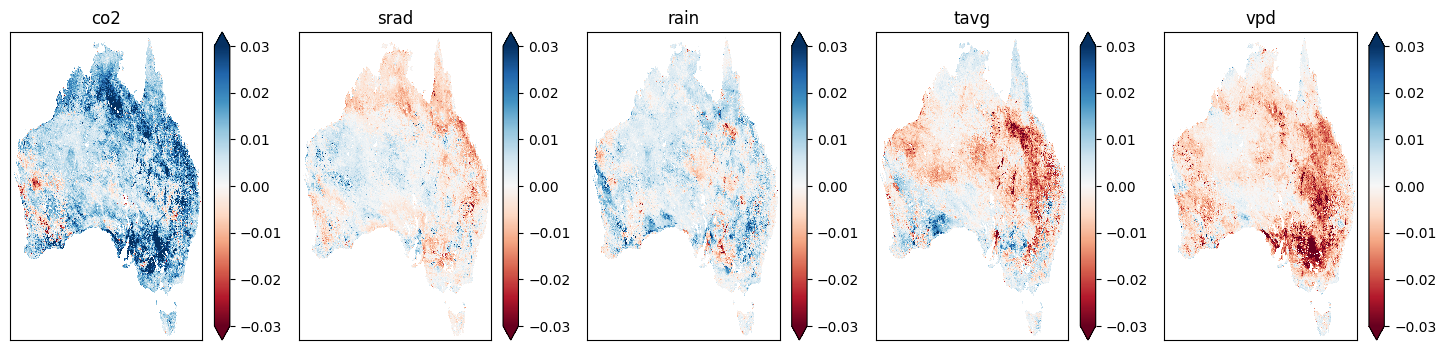

In [37]:
fig,axes=plt.subplots(1,5,figsize=(18,4))
for v,ax in zip(p_attribution.feature.values,axes.ravel()):
    p_attribution.sel(feature=v).PLS_coefficent.plot(add_labels=False,ax=ax, vmin=-0.03,vmax=0.03,cmap='RdBu')
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    ax.set_title(v)

In [40]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

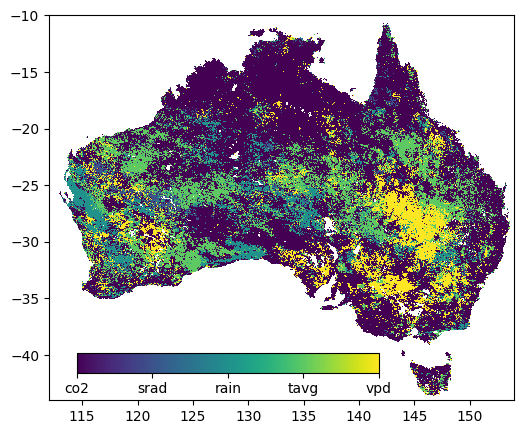

In [47]:
fig,ax=plt.subplots(1,1, figsize=(6,5))

ss = allNaN_arg(np.abs(p_attribution.PLS_coefficent), dim='feature',stat='max', idx=False)
im = ss.plot(add_colorbar=False, ax=ax, add_labels=False)

axins1 = inset_axes(ax,width="65%",height="5%",loc="lower left", borderpad=2)
cbar = fig.colorbar(im,cax=axins1, ticks=[0,1,2,3,4],orientation='horizontal')
cbar.ax.set_xticklabels(list(p_attribution.feature.values));

In [ ]:
# p_trends['vPOS_slope'].odc.explore(
#             tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#            attr = 'Esri',
#            name = 'Esri Satellite'
# )

## Export

In [41]:
p_attribution.to_netcdf('/g/data/os22/chad_tmp/Aus_phenology/results/attribution_vPOS_perpixel.nc')

In [ ]:
# bb = xr.full_like(results[1000], fill_value=np.nan, dtype='float32')
# bb.to_netcdf('/g/data/os22/chad_tmp/Aus_phenology/data/template_pls.nc')

In [ ]:
# base_clim = '/g/data/os22/chad_tmp/AusENDVI/data/5km/'
# co2 = xr.open_dataset(base_clim+'CO2_5km_monthly_1982_2022.nc').rename({'CO2':'co2'})
# rain = xr.open_dataset(base_clim+'rain_5km_monthly_1981_2022.nc').sel(time=slice('1982','2022')).drop_vars('spatial_ref')
# srad = xr.open_dataset(base_clim+'srad_5km_monthly_1982_2022.nc').drop_vars('spatial_ref')
# tavg = xr.open_dataset(base_clim+'tavg_5km_monthly_1982_2022.nc').drop_vars('spatial_ref')
# vpd = xr.open_dataset(base_clim+'vpd_5km_monthly_1982_2022.nc').drop_vars('spatial_ref')
# wcf = xr.open_dataset(base_clim+'WCF_5km_monthly_1982_2022.nc').drop_vars('spatial_ref').rename({'WCF':'wcf'})

# covars = xr.merge([co2, rain, srad, tavg, vpd, wcf])
# covars = assign_crs(covars, crs='EPSG:4326')

# covars = covars.transpose('time', 'latitude','longitude')
# covars = covars.sel(time=slice('1982', '2022'))

# for v in covars.data_vars:
#     try:
#         del covars[v].attrs['grid_mapping']
#     except:
#         continue
# covars.to_netcdf('/g/data/os22/chad_tmp/Aus_phenology/data/covars.nc')